In [1]:
import jax.numpy as np

In [2]:
from jax import grad

In [25]:
from jax import vmap # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax
from jax import random

In [26]:
import matplotlib.pyplot as plt # visualization

In [27]:
# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1)
)

rng = random.PRNGKey(0)
in_shape = (-1, 1)
out_shape, net_params = net_init(rng, in_shape)

In [43]:
def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)

In [44]:
xrange_inputs = np.linspace(-5,5,100).reshape((100, 1)) # (k, 1)
targets = np.sin(xrange_inputs)

In [45]:
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)

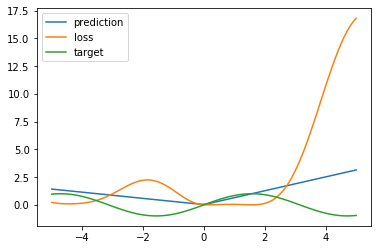

In [46]:
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # per-input loss
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

In [47]:
import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap

In [48]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(net_params)

In [49]:
@jit
def step(i, opt_state, x1, y1):
    p = get_params(opt_state)
    g = grad(loss)(p, x1, y1)
    return opt_update(i, g, opt_state)

In [51]:
for i in range(100):
    opt_state = step(i, opt_state, xrange_inputs, targets)
net_params = get_params(opt_state)

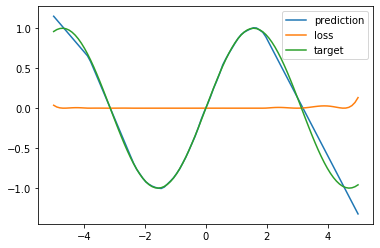

In [54]:
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # per-input loss
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

In [55]:
def inner_update(p, x1, y1, alpha=.1):
    grads = grad(loss)(p, x1, y1)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    return tree_multimap(inner_sgd_fn, grads, p)

def maml_loss(p, x1, y1, x2, y2):
    p2 = inner_update(p, x1, y1)
    return loss(p2, x2, y2)

In [73]:
grad(maml_loss)

<function __main__.grad.<locals>.grad_f(p, x1, y1, x2, y2)>

In [57]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)  # this LR seems to be better than 1e-2 and 1e-4
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(maml_loss)(p, x1, y1, x2, y2)
    l = maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l
K=20

np_maml_loss = []

# Adam optimization
for i in range(20000):
    # define the task
    A = onp.random.uniform(low=0.1, high=.5)
    phase = onp.random.uniform(low=0., high=np.pi)
    # meta-training inner split (K examples)
    x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
    y1 = A * onp.sin(x1 + phase)
    # meta-training outer split (1 example). Like cross-validating with respect to one example.
    x2 = onp.random.uniform(low=-5., high=5.)
    y2 = A * onp.sin(x2 + phase)
    opt_state, l = step(i, opt_state, x1, y1, x2, y2)
    np_maml_loss.append(l)
    if i % 1000 == 0:
        print(i)
net_params = get_params(opt_state)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


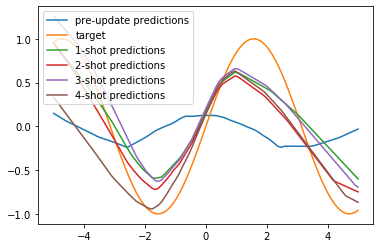

In [58]:
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
y1 = 1. * onp.sin(x1 + 0.)

for i in range(1,5):
    net_params = inner_update(net_params, x1, y1)
    predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
plt.legend()

In [75]:
f = lambda x, y : np.exp(x + y)
g = lambda x : np.square(x)
print(grad(f)(1., 2.)) # = e^{1}
# print(grad(grad(f))(1.))
# print(grad(grad(grad(f)))(1.))

# print(grad(g)(2.)) # 2x = 4
# print(grad(grad(g))(2.)) # x = 2
# print(grad(grad(grad(g)))(2.)) # x = 0

20.085537


In [78]:
grad(f)(1., 2.)

DeviceArray(20.085537, dtype=float32)

In [72]:
grad(f)(3.)

DeviceArray(20.085537, dtype=float32)

In [80]:
# vmapped version of maml loss.
# returns scalar for all tasks.
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = vmap(partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return np.mean(task_losses)

In [81]:
def sample_tasks(outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    As = []
    phases = []
    for _ in range(outer_batch_size):        
        As.append(onp.random.uniform(low=0.1, high=.5))
        phases.append(onp.random.uniform(low=0., high=np.pi))
    def get_batch():
        xs, ys = [], []
        for A, phase in zip(As, phases):
            x = onp.random.uniform(low=-5., high=5., size=(inner_batch_size, 1))
            y = A * onp.sin(x + phase)
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    x2, y2 = get_batch()
    return x1, y1, x2, y2

In [84]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

# vmapped version of maml loss.
# returns scalar for all tasks.
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = vmap(partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return np.mean(task_losses)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(batch_maml_loss)(p, x1, y1, x2, y2)
    l = batch_maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l

np_batched_maml_loss = []
K=20
for i in range(20000):
    x1_b, y1_b, x2_b, y2_b = sample_tasks(4, K)
    opt_state, l = step(i, opt_state, x1_b, y1_b, x2_b, y2_b)
    np_batched_maml_loss.append(l)
    if i % 1000 == 0:
        print(i)
net_params = get_params(opt_state)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


AttributeError: module 'jax.experimental.optimizers' has no attribute 'get_params'

In [85]:
net_params = get_params(opt_state)

In [86]:
net_params

[(DeviceArray([[-0.06613997, -0.18457334, -0.1602599 , -0.02941501,
                 0.08806352,  0.02165045, -0.08512183,  0.07687156,
                -0.0303625 , -0.00229997,  0.14181393,  0.26596007,
                 0.2099497 , -0.16662955, -0.23597942,  0.00085841,
                 0.04210699, -0.30338949, -0.00148206,  0.33055583,
                 0.05919666,  0.14153907,  0.60614729, -0.10746762,
                 0.00701917,  0.01529169, -0.05984478, -0.10848934,
                -0.2646158 , -0.16183409, -0.26156539, -0.01425275,
                 0.02729791, -0.00209383, -0.0251944 ,  0.27401504,
                 0.37149745,  0.3261992 ,  0.23936188, -0.19913323]],
              dtype=float32),
  DeviceArray([-0.20960915, -0.25199527, -0.44856927, -0.03284279,
                0.27358374,  0.14549233, -0.27788633,  0.32580766,
                0.00980698, -0.018962  ,  0.07443088, -0.80755943,
               -0.49655214, -0.09602474, -0.43450767,  0.20691572,
                0.11